Contributors: 
Peter Harmer,
Girish Dodda

In [3]:
%pip install pandas
%pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\giris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\giris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import re

In [5]:
#Initializing
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("GPU available: {}".format(gpu_available))

GPU available: False


In [6]:
#Load & check Data

colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('drive/My Drive/COMP SCI 539/bbc-news-data.csv', delimiter='\t')
else:
    data = pd.read_csv('bbc-news-data.csv', delimiter='\t')

data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


category    0
filename    0
title       0
content     0
dtype: int64


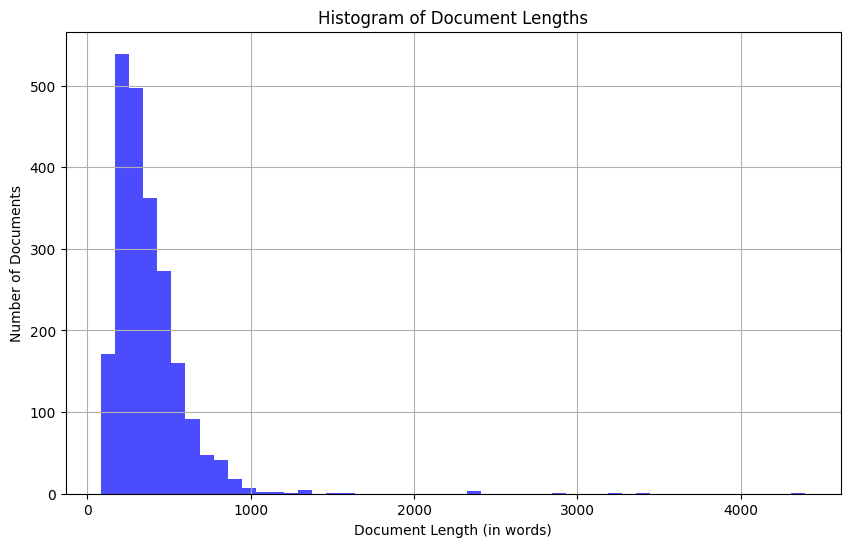

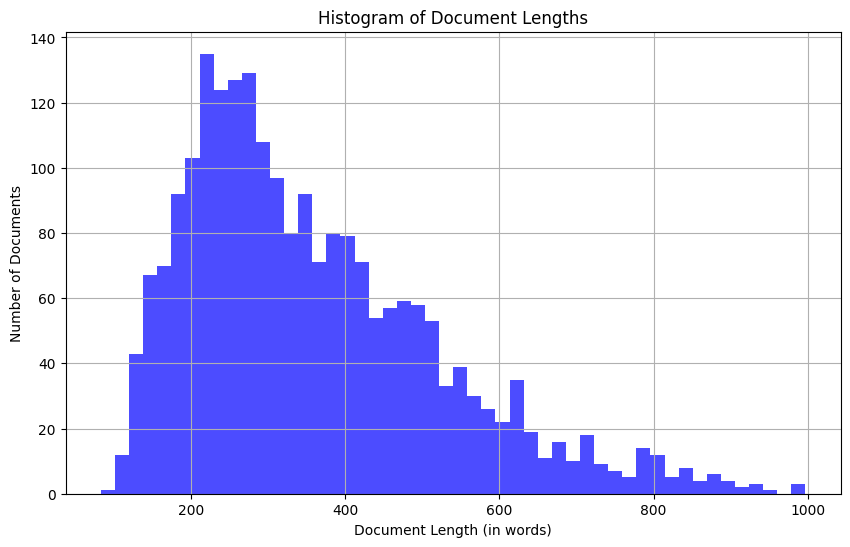

In [7]:
#Data Preprocessing

# Find and remove nulls
print(data.isnull().sum())

# Data to lowercase
data["title"] = data["title"].str.lower()
data["content"] = data["content"].str.lower()
# Remove and replace contractions
#Find more contraction in text and add
contraction_dict = {"can't":"cannot","didn't":"did not","aren't":"are not","she'd":"she would","he'd":"he would","they'd":"they would","they've":"they have",
"shouldn't":"should not","shouldn't've":"should not have","she'll":"she will","he'll":"he will","they'll":"they will"
}

def contraction_replacer(text):
    for word in text.split():
        if word in contraction_dict:
            text = text.replace(word, contraction_dict[word])
    return text

data["title"] = data["title"].apply(contraction_replacer)
data["content"] = data["content"].apply(contraction_replacer)

# Remove punctuation and numbers
#Find more punctuation in text and add

punctuation_numbers = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'

def punctuation_numbers_remover(text):
    for punctuation in punctuation_numbers:
        text = text.replace(punctuation, '')
    return text

data["title"] = data["title"].apply(punctuation_numbers_remover)
data["content"] = data["content"].apply(punctuation_numbers_remover)

data.head()

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]


plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

# remove the outliers
MAX_CONTENT_LENGTH = 1000
MAX_TITLE_LENGTH = 10
# get the indices of the documents that have more than 1000 words
outliers = [idx for idx, length in enumerate(
    content_lengths) if length > MAX_CONTENT_LENGTH]

# remove the outliers from the data
data = data.drop(outliers, axis=0).reset_index(drop=True)

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

In [8]:
class Vocab:
    def __init__(self):
        self.word2index = {"PAD": 0, "UNK": 1}
        self.index2word = {0: "PAD", 1: "UNK"}
        self.word2count = {}
        self.n_words = 2 

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = []

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(
                self.word2index[tkn if tkn in self.word2index else "UNK"])


        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired length
                token_seq_idx += [self.word2index["PAD"]] * \
                    (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])


print("Creating vocab...")
vocab = Vocab()
for content in data["content"]:
    vocab.addSentence(content)

# Test it out
print("Number of words in vocab: {}".format(vocab.n_words))
# pick a random sequence from the data
random_idx = np.random.randint(0, len(data))
print("Original text: {}".format(data["content"][random_idx]))
# tokenize the text
tokenized_text = vocab.tokenize(data["content"][random_idx])
print("Tokenized text: {}".format(tokenized_text))
# convert back to text
converted_text = vocab.list2sentence(tokenized_text)
print("Converted text: {}".format(converted_text))

Creating vocab...
Number of words in vocab: 31568
Original text:  uk broadcaster virgin radio says it will become the first station in the world to offer radio via g mobiles  the radio station in partnership with technology firm sydus will broadcast on selected g and highspeed g networks later this year listeners will be able to download software from the virgin website which enables the service james cridland head of new media at virgin radio said it places radio at the heart of the g revolution virgin radio will be the first station made available followed by two digital stations virgin radio classic rock and virgin radio groove  mr cridland said this application will enable anyone anywhere to listen to virgin radio simply with the phone in their pocket this allows us to tap into a huge new audience and keep radio relevant for a new generation of listeners saumil nanavati president of sydus said this radio player is what the g network was built for giving consumers highquality and hi

In [9]:
def create_dataloaders(batch_size):
    n = len(data)
    print("Creating dataloaders with {} samples...".format(n))
    content_seqs_ids = torch.zeros((n, MAX_CONTENT_LENGTH)).long()
    title_seqs_ids = torch.zeros((n, MAX_TITLE_LENGTH)).long()

    for idx, content in enumerate(data["content"]):
        # Tokenize and add to tensor
        content_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(content, seq_len=MAX_CONTENT_LENGTH))
        
    for idx, title in enumerate(data["title"]):
        title_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(title, seq_len=MAX_TITLE_LENGTH))

    # Split into training and testing
    train_sample_mask = torch.rand((n,)) > 0.3

    train_content_seqs_ids = content_seqs_ids[train_sample_mask]
    train_title_seqs_ids = title_seqs_ids[train_sample_mask]
    test_content_seqs_ids = content_seqs_ids[~train_sample_mask]
    test_title_seqs_ids = title_seqs_ids[~train_sample_mask]
    

    # Create train dataloader
    train_data = TensorDataset(train_content_seqs_ids.to(
        device), train_title_seqs_ids.to(device))
    train_dataloader = DataLoader(
        train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Create test dataloader
    test_data = TensorDataset(test_content_seqs_ids.to(
        device), test_title_seqs_ids.to(device))
    test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=batch_size)

    return train_dataloader, test_dataloader


# Test the dataloader
train_dataloader, test_dataloader = create_dataloaders(32)
for cont, titl in train_dataloader:
    print('Batch | cont =', cont.shape, '| titl =', titl.shape)
    print('First content: ', vocab.list2sentence(cont[0].tolist()))
    print('First title:', vocab.list2sentence(titl[0].tolist()))
    break

Creating dataloaders with 2204 samples...
Batch | cont = torch.Size([32, 1000]) | titl = torch.Size([32, 10])
First content:  arsenal manager arsene wenger has signed a new contract to stay at the club until may wenger has ended speculation about his future by agreeing a longterm contract that takes him beyond the opening of arsenal's new stadium in two years he said signing a new contract just rubberstamps my desire to take this club forward and fulfil my ambitions i still have so much to achieve and my target is to drive this club on these are exciting times for arsenal the yearold frenchman told arsenal's website wwwarsenalcom my intention has always been clear i love this club and am very happy here wenger has won the title and the fa cup three times each during his reign chairman peter hillwood said we are absolutely delighted that arsene has signed an extension to his contract since his arrival in he has revolutionised the club both on and off the pitch as well as the six major h

In [10]:
sentence = 'the fat cat sat on the white hat with a big brown bat'
seq = torch.tensor([vocab.word2index[w]
                      for w in sentence.split()]).unsqueeze(0)
print(seq.shape)

torch.Size([1, 13])


In [11]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.rnn = nn.LSTM(input_size=d_model, hidden_size=d_model,
                           num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        # Shape `(batch_size, seq_len, d_model)`.
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs  # Shape `(batch_size, seq_len, d_model)`.
    

# Example usage
rnn_encoder = RNNEncoder(vocab_size=vocab.n_words,
                         d_model=512, num_layers=3, dropout_rate=0.1).to(device)
print('Batch of Contents:', seq.shape)
print('Output of RNN Encoder:', rnn_encoder(seq.to(device)).shape)

Batch of Contents: torch.Size([1, 13])
Output of RNN Encoder: torch.Size([1, 13, 512])


In [12]:
class ExtractiveSummarizer(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1, threshold=0.5, sum_len = 10, pad_token = 0):
        super().__init__()
        self.encoder = RNNEncoder(
            vocab_size, d_model, num_layers, dropout_rate)
        self.scoring_layer = nn.Linear(d_model, 1)
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.sum_len = sum_len
        self.pad_token = pad_token

    def forward(self, x):
        # Encoder outputs
        # Shape `(batch_size, seq_len, d_model)`.
        encoder_outputs = self.encoder(x)

        # Scoring each word
        # Shape `(batch_size, seq_len)`.
        scores = self.scoring_layer(encoder_outputs).squeeze(-1)
        selected = scores > self.threshold

        return scores, selected


summarizer = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=512, num_layers=3, dropout_rate=0.1, threshold=0.6, sum_len=MAX_TITLE_LENGTH, pad_token=vocab.word2index["PAD"]).to(device)

# Get the scores and selected words
scores, selected = summarizer(seq)

# Print the results
print("Scores:\n", scores)
print("Selected (Binary Mask):\n", selected)

Scores:
 tensor([[0.0410, 0.0451, 0.0423, 0.0430, 0.0415, 0.0421, 0.0430, 0.0427, 0.0455,
         0.0485, 0.0481, 0.0474, 0.0449]], grad_fn=<SqueezeBackward1>)
Selected (Binary Mask):
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False]])


In [13]:
def selectedToSummary(selected, scores, x, sum_len, pad_token):
    top_scores, top_indices = torch.topk(
        scores, k=sum_len, dim=-1, sorted=False)
    # Initialize an empty tensor for the summary indices

    summary_tokens = torch.full((x.size(
        0), sum_len), fill_value=pad_token, dtype=torch.long, device=x.device)
    # Fill in the indices of the top scoring words

    for i in range(x.size(0)):  # Loop over batch
        # Number of selected words or sum_len
        length = min(sum_len, (selected[i]).sum().item())
        summary_tokens[i, :length] = top_indices[i, :length]

    return summary_tokens

def summaryToSelected(summary, x, pad_idx):
    selected = torch.zeros_like(x, dtype=torch.bool)

    # Loop through all batches
    for i in range(x.size(0)):
        for j in range(summary.size(1)):
            if(summary[i, j] != pad_idx):
                # find the index of the summary token in the original sequence
                idx = (x[i] == summary[i, j]).nonzero(as_tuple=True)[0]
                selected[i, idx] = True

    return selected

# Test the functions
summary_tokens = selectedToSummary(selected, scores, seq, MAX_TITLE_LENGTH, vocab.word2index["PAD"])
print("Summary Tokens:\n", summary_tokens)
print("Summary:\n", vocab.list2sentence(summary_tokens[0].tolist()))


# Test the functions
summary_tokens = vocab.tokenize(data["title"][random_idx], seq_len=MAX_TITLE_LENGTH)
summary_tokens = torch.tensor(summary_tokens).unsqueeze(0)

selected = summaryToSelected(summary_tokens, seq, vocab.word2index["PAD"])
print("Summary Tokens:\n", summary_tokens)
print("Selected:\n", selected)

Summary Tokens:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Summary:
 PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Summary Tokens:
 tensor([[5478, 1474, 3652,  254, 7069,    0,    0,    0,    0,    0]])
Selected:
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False]])


In [19]:
#Hyperparameters
dropout = 0.1
hidden_dim = 256
num_layers = 2
threshold = 0.5
lr= 0.01
epochs = 10
summation_length = MAX_TITLE_LENGTH

In [20]:
import os
import torch
import torch.nn as nn

import torch.optim as optim
import matplotlib.pyplot as plt

from rouge_score import rouge_scorer


def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores


def fit(model, dataloader, optimizer, criterion, epochs, device):
    model.train()

    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        dataloader_size = len(dataloader)
        
        for i, batch in enumerate(dataloader):
            print(f'Batch {i}/{dataloader_size}', end='\r')
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            targets_selected = summaryToSelected(targets, inputs, vocab.word2index["PAD"]).to(device)

            # Forward pass
            scores, selected = model(inputs)
            probabilities = torch.sigmoid(scores)
            # print(targets.shape, outputs.shape)

            loss = criterion(probabilities, targets_selected.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        torch.save(model.state_dict(), './model.pth')

    return loss_history


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    rouge1 = 0
    rougeL = 0
    with torch.no_grad():
        dataloader_size = len(dataloader)
        

        for i, batch in enumerate(dataloader):
            print(f'Batch {i}/{dataloader_size}', end='\r')

            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            targets_selected = summaryToSelected(targets, inputs, vocab.word2index["PAD"]).to(device)

            scores, selected = model(inputs)
            probabilities = torch.sigmoid(scores)

            summary_tokens = selectedToSummary(
                selected, scores, inputs, summation_length, vocab.word2index["PAD"])
            generated_summaries = [vocab.list2sentence(list(filter(
                lambda x: x != 0, summary_tokens[i].tolist()))) for i in range(summary_tokens.size(0))]
            references = [vocab.list2sentence(
                list(filter(lambda x: x != 0, targets[i].tolist()))) for i in range(targets.size(0))]
            
            for reference, generated_summary in zip(references, generated_summaries):
                score = calculate_rouge(
                    reference, generated_summary)
                rouge1 += score['rouge1'].fmeasure
                rougeL += score['rougeL'].fmeasure

            # Same as in fit function, adjust loss calculation based on output and target format
            loss = criterion(probabilities, targets_selected.float())

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_rouge1 = rouge1 / len(dataloader.dataset)
    avg_rougeL = rougeL / len(dataloader.dataset)

    return avg_loss, (avg_rouge1, avg_rougeL)# Example usage

# Assuming you have a dataloader for training and validation


batch_size = 32
train_dataloader, test_dataloader = create_dataloaders(batch_size)

load_model = True
keep_training = True

criterion = F.binary_cross_entropy

# Check if the model file exists
if os.path.exists("./model.pth") and load_model:
    print("Loading saved model...")
    model = ExtractiveSummarizer(vocab.n_words, hidden_dim, num_layers, dropout, threshold).to(device)
    model.load_state_dict(torch.load("./model.pth"))

    if keep_training:
        print("Continuing training...")
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
        torch.save(model.state_dict(), './model.pth')

else :
    print("Creating new model...")
    model = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=hidden_dim, num_layers=num_layers, dropout_rate=dropout, threshold=threshold).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
    torch.save(model.state_dict(), './model.pth')


val_loss, rouge_scores = evaluate(model, test_dataloader, criterion, device)
print(f'Validation loss: {val_loss:.4f}')
print(f'Validation rouge1: {rouge_scores[0]:.4f}')
print(f'Validation rougeL: {rouge_scores[1]:.4f}')

# Plotting
# plt.plot(train_loss_history, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Time')
# plt.legend()
# plt.show()

Creating dataloaders with 2204 samples...
Loading saved model...
Continuing training...
Epoch 1/10, Loss: 0.0228
Epoch 2/10, Loss: 0.0181
Epoch 3/10, Loss: 0.0159
Epoch 4/10, Loss: 0.0145
Epoch 5/10, Loss: 0.0132
Epoch 6/10, Loss: 0.0124
Epoch 7/10, Loss: 0.0116
Epoch 8/10, Loss: 0.0113
Epoch 9/10, Loss: 0.0112
Epoch 10/10, Loss: 0.0105
Validation loss: 0.0242
Validation rouge1: 0.0176
Validation rougeL: 0.0176


In [18]:
import random

def test_random_batches(dataloader, n):
    all_indices = list(range(len(dataloader)))
    random_idx = random.sample(all_indices, n)
    tests = [dataloader.dataset[i] for i in random_idx]

    for i, test in enumerate(tests):
        print(f'Test {i+1}/{n}')
        inputs, targets = test
        inputs, targets = inputs.unsqueeze(0).to(device), targets.unsqueeze(0).to(device)

        scores, selected = model(inputs)
        probabilities = torch.sigmoid(scores)

        summary_tokens = selectedToSummary(selected, scores, inputs, summation_length, vocab.word2index["PAD"])

        print("Summary:\n", vocab.list2sentence(summary_tokens[0].tolist()))
        print("Target:\n", vocab.list2sentence(targets[0].tolist()))
        print("Input:\n", vocab.list2sentence(inputs[0].tolist()))
        print("")

test_random_batches(test_dataloader, 10)

Test 1/10
Summary:
 greatly oneoff at UNK try gains buoyed  firm revenues
Target:
 strong demand UNK oil rally PAD PAD PAD PAD PAD
Input:
 crude oil prices surged back above the a barrel mark on thursday after an energy market watchdog raised its forecasts for global demand the international energy agency iea warned demand for opec's crude in the first quarter would outstrip supply the iea raised its estimate of oil demand growth by barrels a day to million barrels a day us light crude rose to while brent crude in london gained to the parisbased iea watchdog which advises industrialized nations on energy policy said the upward revision was due to stronger demand from china and other asian countries the fresh rally in crude prices followed gains on wednesday which were triggered by large falls in us crude supplies following a cold spell in north america in january the us department of energy reported that crude stockpiles had fallen m barrels to m on top of that ongoing problems for bel